# Homework 2

## FINM 37500: Fixed Income Derivatives

* Matheus Raka Pradnyatama

#### Winter 2025

In [1]:
import pandas as pd
import numpy as np
import datetime
import holidays
import seaborn as sns
import math

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.linear_model import LinearRegression

from scipy.optimize import minimize
from scipy import interpolate
from scipy.optimize import fsolve
from scipy.stats import norm

from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
import numpy.polynomial.polynomial as poly

In [2]:
def calc_fwdswaprate(discounts, Tfwd, Tswap, freqswap):
    "Tfwd = time to the forward exercise date"
    "Tswap = time to swaption expiration date"
    "freqswap = Swap payment frequency"
    
    # Calculate the frequency of discount periods by converting the index to a series,
    # finding the average difference between consecutive periods, and taking its reciprocal.
    # Then round the result to get an integer frequency.
    freqdisc = round(1 / discounts.index.to_series().diff().mean())

    # Number of discount periods that correspond to one swap period
    # Discount frequency / swap frequency
    step = round(freqdisc / freqswap)
    
    # Position in the index corresponding to the forward date: Tfwd.
    periods_fwd = discounts.index.get_loc(Tfwd)
    # Position in the index corresponding to the swap date: Tswap.
    periods_swap = discounts.index.get_loc(Tswap)
    
    # Adjust the indices to set the slice boundaries:
    # Move the forward period index forward by one 'step' to exclude the left boundary.
    periods_fwd += step
    # Increment the swap period index by one to include the right boundary in the slice.
    periods_swap += 1
    
    # Calculate the forward swap rate:
    # Numerator = Swap payment frequency x (Discount factors at Tfwd - Discount Factor at Tswap)
    # Denominator =  sum of discount factors over the specified slice (from periods_fwd to periods_swap stepping by 'step').
    fwdswaprate = freqswap * (discounts.loc[Tfwd] - discounts.loc[Tswap]) / discounts.iloc[periods_fwd:periods_swap:step].sum()
    
    # Return the calculated forward swap rate.
    return fwdswaprate

def blacks_formula(T,vol,strike,fwd,discount, isCall=True):
    # Price of call option
    sigT = vol * np.sqrt(T)
    d1 = (1/sigT) * np.log(fwd/strike) + .5*sigT
    d2 = d1-sigT
    
    if isCall:
        # Payer swaption (acts like a call)
        val = discount * (fwd * norm.cdf(d1) - strike * norm.cdf(d2))
    else:
        # Receiver swaption (acts like a Put)
        val = discount * (strike * norm.cdf(-d2) - fwd * norm.cdf(-d1))
    return val

### SABR

def alpha_polynomial(beta, nu, rho, T, volATM, f):
    
    coefs = np.ones(4)
    coefs[0] = (1-beta)**2 * T / (24*f**(2-2*beta))
    coefs[1] = rho * beta * nu * T / (4*f**(1-beta))
    coefs[2] = 1 + (2-3*rho**2) * nu**2 * T / 24
    coefs[3] = -volATM * f**(1-beta)
    
    return np.poly1d(coefs)

def solve_alpha(beta, nu, rho, T, volATM, f):
    coefs = np.ones(4)
    coefs[3] = (1-beta)**2 * T / (24*f**(2-2*beta))
    coefs[2] = rho * beta * nu * T / (4*f**(1-beta))
    coefs[1] = 1 + (2-3*rho**2) * nu**2 * T / 24
    coefs[0] = -volATM * f**(1-beta)

    roots = poly.polyroots(coefs)
    alpha = np.real(roots[np.abs(np.imag(roots))<1e-6][0])
    return alpha

def zfun(beta, nu, alpha, f, K):
    return (nu/alpha) * (f*K)**((1-beta)/2) * np.log(f/K)

def chi(z, rho):
    return np.log((np.sqrt(1-2*rho*z + z**2) + z - rho) / (1-rho))

def sabr_slim(beta,nu,rho,f,K,T,volATM):

    alpha = solve_alpha(beta, nu, rho, T, volATM, f)
    
    squareNUM = (((1-beta)**2)/24) * (alpha**2)/((f*K)**(1-beta)) + (1/4) * (rho*beta*nu*alpha)/((f*K)**((1-beta)/2))+((2-3*rho**2)/24)*nu**2
    NUM = alpha * (1 + squareNUM * T)
    squareDEN = 1 + (((1-beta)**2)/24) * ((np.log(f/K))**2) + (((1-beta)**4)/1920) * ((np.log(f/K))**4)
    DEN = (f*K)**((1-beta)/2) * squareDEN
    z = zfun(beta,nu,alpha,f,K)
    sigmaB = (NUM/DEN) * (z/chi(z,rho))
        
    if (type(K) is np.float64) | (type(K) is float):
        if (f==K):
            sigmaB = sabrATM(beta,nu,rho,alpha,f,K,T)
    else:
        mask = f==K
        sigmaB[mask] = sabrATM(beta,nu,rho,alpha,f,K[mask],T)
        
    return sigmaB

def sabr(beta,nu,rho,alpha,f,K,T):
   
    squareNUM = (((1-beta)**2)/24) * (alpha**2)/((f*K)**(1-beta)) + (1/4) * (rho*beta*nu*alpha)/((f*K)**((1-beta)/2))+((2-3*rho**2)/24)*nu**2
    NUM = alpha * (1 + squareNUM * T)
    squareDEN = 1 + (((1-beta)**2)/24) * (np.log(f/K)**2) + (((1-beta)**4)/1920) * (np.log(f/K)**4)
    DEN = (f*K)**((1-beta)/2) * squareDEN
    z = zfun(beta,nu,alpha,f,K)        
    sigmaB = (NUM/DEN) * (z/chi(z,rho))
    
    if (type(K) is np.float64) | (type(K) is float):
        if f==K:
            sigmaB = sabrATM(beta,nu,rho,alpha,f,K,T)
    else:
        mask = f==K
        sigmaB[mask] = sabrATM(beta,nu,rho,alpha,f,K[mask],T)
        
    return sigmaB

def sabrATM(beta,nu,rho,alpha,f,K,T):
    brack = (((1-beta)**2)/24) * ((alpha**2)/(f**(2-2*beta))) + (rho * beta * nu * alpha)/(4*f**(1-beta)) + ((2-3*rho**2)/24) * nu**2
    
    sigma = alpha * (1+brack*T) / f**(1-beta)

    return sigma

***

# 1.

## Swaption Vol Data

The file `data/swaption_vol_data_2025-01-31.xlsx` has market data on the implied volatility skews for swaptions. Note that it has several columns:
* `expry`: expiration of the swaption
* `tenor`: tenor of the underlying swap
* `model`: the model by which the volatility is quoted. (All are Black.)
* `-200`, `-100`, etc.: The strike listed as difference from ATM strike (bps). Note that ATM is considered to be the **forward swapa rate** which you can calculate.

Your data: ywill use a single row of this data for the `1x4` swaption.
* date: `2025-01-31`
* expiration: 1yr
* tenor: 4yrs

In [3]:
filepath_rawdata = f'../data/swaption_vol_data_2025-01-31.xlsx'
volquote = pd.read_excel(filepath_rawdata)
volquote.index = ['implied vol']
volquote.head(20)

,reference,instrument,model,date,expiration,tenor,-200,-100,-50,-25,0,25,50,100,200
implied vol,SOFR,swaption,black,2025-01-31,1,4,42.13,31.51,28.15,26.89,25.9,25.16,24.66,24.23,24.73


## Rate Data

The file `data/cap_curves_2025-01-31.xlsx` gives 
* SOFR swap rates, 
* their associated discount factors
* their associated forward interest rates.

You will not need the cap data (flat or forward vols) for this problem.

In [4]:
filepath_rawdata = f'../data/cap_curves_2025-01-31.xlsx'
curvedata = pd.read_excel(filepath_rawdata)
curvedata.set_index('tenor',inplace=True)

curvedata.head()

,swap rates,spot rates,discounts,forwards,flat vols,fwd vols
tenor,,,,,,
0.25,0.042340,0.042340,0.989526,NaN,NaN,NaN
0.50,0.041854,0.041852,0.979398,0.041364,0.101500,0.101500
0.75,0.041404,0.041397,0.969584,0.040489,0.116946,0.128478
1.00,0.041029,0.041018,0.960012,0.039882,0.132391,0.154562
1.25,0.040458,0.040438,0.950950,0.038117,0.159421,0.219138


## The Swaption

Consider the following swaption with the following features:
* underlying is a fixed-for-floating (SOFR) swap
* the underlying swap has **quarterly** payment frequency
* this is a **payer** swaption, which gives the holder the option to **pay** the fixed swap rate and receive SOFR.

### 1.1
Calculate the (relevant) forward swap rate. That is, the one-year forward 4-year swap rate.

In [5]:
# Option Expiry Date
Topt = 1
# Tenor of the Swap
tenor_swap = 4

# Tenor of Swaption = Option Expiration time + Swap Tenor
T_swaption = Topt + tenor_swap

# Formula Inputs
discounts = curvedata['discounts']
# Time for Forward Exercise = Option's Tenor
Tfwd = Topt
Tswap = T_swaption
# Quarterly Payment Frequency for the swap
freqswap = 4

fwdswap = calc_fwdswaprate(discounts, Tfwd, Tswap, freqswap)
print(f"The forward swap rate is: {fwdswap:.4%}")


The forward swap rate is: 3.9385%


### 1.2
Price the swaptions at the quoted implied volatilites and corresponding strikes, all using the just-calculated forward swap rate as the underlying.

In [6]:
volquote

,reference,instrument,model,date,expiration,tenor,-200,-100,-50,-25,0,25,50,100,200
implied vol,SOFR,swaption,black,2025-01-31,1,4,42.13,31.51,28.15,26.89,25.9,25.16,24.66,24.23,24.73


In [7]:
# Difference from ATM Strike Price
strikerange = np.array(volquote.columns[-9:].tolist())
strikerange

array([-200, -100,  -50,  -25,    0,   25,   50,  100,  200])

In [8]:
# Column names of Difference from ATM Strike Price
strikerange = np.array(volquote.columns[-9:].tolist())

# Implied Volatilities
# Initially were in percentages, convert to real numbers
vols = volquote[strikerange] / 100
vols

,-200,-100,-50,-25,0,25,50,100,200
implied vol,0.4213,0.3151,0.2815,0.2689,0.259,0.2516,0.2466,0.2423,0.2473


In [9]:
# Strike Rates = Forward Swap Rate + Difference from ATM Strike Rate (convert from bps to actual numbers)
strikes = fwdswap + strikerange/10_000

# Put the Strikes into the dataframe
blacks_quotes = vols.copy()
blacks_quotes.loc['strikes'] = strikes
blacks_quotes

,-200,-100,-50,-25,0,25,50,100,200
implied vol,0.421300,0.315100,0.281500,0.268900,0.259000,0.251600,0.246600,0.242300,0.247300
strikes,0.019385,0.029385,0.034385,0.036885,0.039385,0.041885,0.044385,0.049385,0.059385


In [10]:
# This part is unnecessary
QUOTE_STYLE = 'black'
# if QUOTE_STYLE == 'normal':
#     vols /= 100 * fwdrate

volATM = blacks_quotes.loc['implied vol', 0]
strike_ATM = blacks_quotes.loc['strikes', 0]

print(f"The ATM Strike Rate is: {strike_ATM:.4%}")
print(f"The ATM Implied Vol is: {volATM:.4f}")

The ATM Strike Rate is: 3.9385%
The ATM Implied Vol is: 0.2590


In [11]:
curvedata.head()

,swap rates,spot rates,discounts,forwards,flat vols,fwd vols
tenor,,,,,,
0.25,0.042340,0.042340,0.989526,NaN,NaN,NaN
0.50,0.041854,0.041852,0.979398,0.041364,0.101500,0.101500
0.75,0.041404,0.041397,0.969584,0.040489,0.116946,0.128478
1.00,0.041029,0.041018,0.960012,0.039882,0.132391,0.154562
1.25,0.040458,0.040438,0.950950,0.038117,0.159421,0.219138


In [12]:
# Row/index position of the Tenor Option (1) in the Dataframe
period_fwd = curvedata.index.get_loc(Topt)
period_fwd

3

In [13]:
# Row/index position of the Tenor Swap (5) + 1 in the Dataframe
period_swap = curvedata.index.get_loc(Tswap)+1
period_swap

20

In [14]:
# Compounding frequency of the Discount Curve
freqcurve = 4

# Row/index position of the Tenor Option (1) in the Dataframe
period_fwd = curvedata.index.get_loc(Topt)

# Row/index position of the Tenor Swap (5) + 1 in the Dataframe
period_swap = curvedata.index.get_loc(Tswap)+1
step = round(freqcurve/freqswap)

# Discount Factor
sum_discount = curvedata['discounts'].iloc[period_fwd + step : period_swap : step].sum()/freqswap
print(f"Sum of the Discount Factors is: {sum_discount:.4f}")

Sum of the Discount Factors is: 3.5391


In [15]:
# Calculating Swaption Price

# Compounding frequency of the Discount Curve
freqcurve = 4
# Sum of Discount Factor Calculation
period_fwd = curvedata.index.get_loc(Topt)
period_swap = curvedata.index.get_loc(Topt+tenor_swap)+1
step = round(freqcurve/freqswap)
sum_discount = curvedata['discounts'].iloc[period_fwd + step : period_swap : step].sum()/freqswap

# Formula Inputs
N = 100
T = Topt
vol = vols.loc[['implied vol']] # Flat vol
strike = strikes
fwd = fwdswap
# Use the sum of discount 
discount = sum_discount

# Payer Swaption Price = N x Call Option Price (via Black's Formula)
swaption_price = N * blacks_formula(T, vol, strike, fwd, discount, isCall=True)[0]
swaption_price

array([7.15552522, 3.89717089, 2.5112578 , 1.92832254, 1.4362333 ,
       1.03992958, 0.73635395, 0.35524075, 0.08468189])

In [16]:
blacks_quotes.loc['price'] = swaption_price

blacks_quotes.style.format('{:.2%}').format('{:.2f}',subset=pd.IndexSlice['price',:])

,-200,-100,-50,-25,0,25,50,100,200
implied vol,42.13%,31.51%,28.15%,26.89%,25.90%,25.16%,24.66%,24.23%,24.73%
strikes,1.94%,2.94%,3.44%,3.69%,3.94%,4.19%,4.44%,4.94%,5.94%
price,7.16,3.90,2.51,1.93,1.44,1.04,0.74,0.36,0.08


### 1.3
To consider how the expiration and tenor matter, calculate the prices of a few other swaptions for comparison. 
* No need to get other implied vol quotes--just use the ATM implied vol you have for the swaption above. (Here we are just interested in how Black's formula changes with changes in tenor and expiration.)
* No need to calculate for all the strikes--just do the ATM strike.

Alternate swaptions
* The 3mo x 4yr swaption
* The 2yr x 4yr swaption
* the 1yr x 2yr swaption

Report these values and compare them to the price of the `1y x 4y` swaption.

In [17]:
print(f"The ATM Strike Rate is: {strike_ATM:.4%}")
print(f"The ATM Implied Vol is: {volATM:.4f}")
# Initially
print(f"Initially, we have a {Topt}-year {tenor_swap}-year swaption")

The ATM Strike Rate is: 3.9385%
The ATM Implied Vol is: 0.2590
Initially, we have a 1-year 4-year swaption


In [18]:
# For a 3mo x 4 year swaption
Topt = 0.25
tenor_swap = 4
tenor_swaption = Topt + tenor_swap
Tswap = tenor_swaption

# Formula inputs for Forward Swap Rate
# Time for Forward Exercise = Option's Tenor
Tfwd = Topt
# Use the swaption's tenor, not just the swap
Tswap = T_swaption
freqswap = 4
discounts = curvedata['discounts']

fwdswap = calc_fwdswaprate(discounts, Tfwd, Tswap, freqswap)
print(f"The forward swap rate is: {fwdswap:.4%}")

# Calculating Swaption Price

# Compounding frequency of the Discount Curve
freqcurve = 4
# Sum of Discount Factor Calculation
period_fwd = curvedata.index.get_loc(Topt)
period_swap = curvedata.index.get_loc(Topt+tenor_swap)+1
step = round(freqcurve/freqswap)
sum_discount = curvedata['discounts'].iloc[period_fwd + step : period_swap : step].sum()/freqswap

# Formula Inputs
N = 100
T = Topt
vol = volATM
strike = strike_ATM
fwd = fwdswap
# Use the sum of discount 
discount = sum_discount

# Payer Swaption Price = N x Call Option Price (via Black's Formula)
swaption_price_3m4y = N * blacks_formula(T, vol, strike, fwd, discount, isCall=True)
print(f"Price for {Topt}-year {tenor_swap}-year Swaption is: ${swaption_price_3m4y:.4f}")

The forward swap rate is: 3.9589%
Price for 0.25-year 4-year Swaption is: $0.7808


In [19]:
# For a 2-year x 4-year swaption
Topt = 2
tenor_swap = 4
tenor_swaption = Topt + tenor_swap
Tswap = tenor_swaption

# Formula inputs for Forward Swap Rate
# Time for Forward Exercise = Option's Tenor
Tfwd = Topt
# Use the swaption's tenor, not just the swap
Tswap = T_swaption
freqswap = 4
discounts = curvedata['discounts']

fwdswap = calc_fwdswaprate(discounts, Tfwd, Tswap, freqswap)
print(f"The forward swap rate is: {fwdswap:.4%}")

# Calculating Swaption Price

# Compounding frequency of the Discount Curve
freqcurve = 4
# Sum of Discount Factor Calculation
period_fwd = curvedata.index.get_loc(Topt)
period_swap = curvedata.index.get_loc(Topt+tenor_swap)+1
step = round(freqcurve/freqswap)
sum_discount = curvedata['discounts'].iloc[period_fwd + step : period_swap : step].sum()/freqswap

# Formula Inputs
N = 100
T = Topt
vol = volATM
strike = strike_ATM
fwd = fwdswap
# Use the sum of discount 
discount = sum_discount

# Payer Swaption Price = N x Call Option Price (via Black's Formula)
swaption_price_2y4y = N * blacks_formula(T, vol, strike, fwd, discount, isCall=True)
print(f"Price for {Topt}-year {tenor_swap}-year Swaption is: ${swaption_price_2y4y:.4f}")

The forward swap rate is: 3.9621%
Price for 2-year 4-year Swaption is: $1.9933


In [20]:
# For a 1-year x 2-year swaption
Topt = 1
tenor_swap = 2
tenor_swaption = Topt + tenor_swap
Tswap = tenor_swaption

# Formula inputs for Forward Swap Rate
# Time for Forward Exercise = Option's Tenor
Tfwd = Topt
# Use the swaption's tenor, not just the swap
Tswap = T_swaption
freqswap = 4
discounts = curvedata['discounts']

fwdswap = calc_fwdswaprate(discounts, Tfwd, Tswap, freqswap)
print(f"The forward swap rate is: {fwdswap:.4%}")

# Calculating Swaption Price

# Compounding frequency of the Discount Curve
freqcurve = 4
# Sum of Discount Factor Calculation
period_fwd = curvedata.index.get_loc(Topt)
period_swap = curvedata.index.get_loc(Topt+tenor_swap)+1
step = round(freqcurve/freqswap)
sum_discount = curvedata['discounts'].iloc[period_fwd + step : period_swap : step].sum()/freqswap

# Formula Inputs
N = 100
T = Topt
vol = volATM
strike = strike_ATM
fwd = fwdswap
# Use the sum of discount 
discount = sum_discount

# Payer Swaption Price = N x Call Option Price (via Black's Formula)
swaption_price_1y2y = N * blacks_formula(T, vol, strike, fwd, discount, isCall=True)
print(f"Price for {Topt}-year {tenor_swap}-year Swaption is: ${swaption_price_1y2y:.4f}")

The forward swap rate is: 3.9385%
Price for 1-year 2-year Swaption is: $0.7463


In [21]:
# For a 1-year x 4-year swaption
Topt = 1
tenor_swap = 4
tenor_swaption = Topt + tenor_swap
Tswap = tenor_swaption

# Formula inputs for Forward Swap Rate
# Time for Forward Exercise = Option's Tenor
Tfwd = Topt
# Use the swaption's tenor, not just the swap
Tswap = T_swaption
freqswap = 4
discounts = curvedata['discounts']

fwdswap = calc_fwdswaprate(discounts, Tfwd, Tswap, freqswap)
print(f"The forward swap rate is: {fwdswap:.4%}")

# Calculating Swaption Price

# Compounding frequency of the Discount Curve
freqcurve = 4
# Sum of Discount Factor Calculation
period_fwd = curvedata.index.get_loc(Topt)
period_swap = curvedata.index.get_loc(Topt+tenor_swap)+1
step = round(freqcurve/freqswap)
sum_discount = curvedata['discounts'].iloc[period_fwd + step : period_swap : step].sum()/freqswap

# Formula Inputs
N = 100
T = Topt
vol = volATM
strike = strike_ATM
fwd = fwdswap
# Use the sum of discount 
discount = sum_discount

# Payer Swaption Price = N x Call Option Price (via Black's Formula)
swaption_price_1y4y = N * blacks_formula(T, vol, strike, fwd, discount, isCall=True)
print(f"Price for {Topt}-year {tenor_swap}-year Swaption is: ${swaption_price_1y4y:.4f}")

The forward swap rate is: 3.9385%
Price for 1-year 4-year Swaption is: $1.4362


In [22]:
print(f"Price for {3}-mo x {4}-yr Swaption is: ${swaption_price_3m4y:.4f}")
print(f"Price for {1}-yr x {4}-yr Swaption is: ${swaption_price_1y4y:.4f}")
print(f"Price for {2}-yr x {4}-yr Swaption is: ${swaption_price_2y4y:.4f}")
print(f"Price for {1}-yr x {2}-yr Swaption is: ${swaption_price_1y2y:.4f}")

Price for 3-mo x 4-yr Swaption is: $0.7808
Price for 1-yr x 4-yr Swaption is: $1.4362
Price for 2-yr x 4-yr Swaption is: $1.9933
Price for 1-yr x 2-yr Swaption is: $0.7463


More time to exercise the option, the more expensive the swaption becomes.

***

# 2. SABR Volatility Modeling

Use the quoted volatility skew to fit a SABR model.
* Throughout, parameterize, `beta=.75`.

In [23]:
BETA = 0.75

### 2.1.
Estimate $(\alpha,\rho,\nu)$ via the SABR formula. Feel free to use the `sabr` function in `cmds/volskew.py`.

Report the values of these parameters.

In [24]:
# For a 1-year x 4-year swaption
Topt = 1
tenor_swap = 4
tenor_swaption = Topt + tenor_swap
Tswap = tenor_swaption

# Formula inputs for Forward Swap Rate
# Time for Forward Exercise = Option's Tenor
Tfwd = Topt
# Use the swaption's tenor, not just the swap
Tswap = T_swaption
freqswap = 4
discounts = curvedata['discounts']

fwdswap = calc_fwdswaprate(discounts, Tfwd, Tswap, freqswap)
print(f"The forward swap rate is: {fwdswap:.4%}")

# Calculating Swaption Price

# Compounding frequency of the Discount Curve
freqcurve = 4
# Sum of Discount Factor Calculation
period_fwd = curvedata.index.get_loc(Topt)
period_swap = curvedata.index.get_loc(Topt+tenor_swap)+1
step = round(freqcurve/freqswap)
sum_discount = curvedata['discounts'].iloc[period_fwd + step : period_swap : step].sum()/freqswap

# Formula Inputs
N = 100
T = Topt
vol = volATM
strike = strike_ATM
fwd = fwdswap
# Use the sum of discount 
discount = sum_discount

# Payer Swaption Price = N x Call Option Price (via Black's Formula)
swaption_price_1y4y = N * blacks_formula(T, vol, strike, fwd, discount, isCall=True)
print(f"Price for {Topt}-year {tenor_swap}-year Swaption is: ${swaption_price_1y4y:.4f}")

The forward swap rate is: 3.9385%
Price for 1-year 4-year Swaption is: $1.4362


In [25]:
# Computing the SABR Parameters 

# Inputs
doSLIM = False
BETA = 0.75
F = fwdswap-1e-8

def obj_fun(xargs):
    nu = xargs[0]
    rho = xargs[1]
    alpha = xargs[2]
    
    ivolSABR = np.zeros(len(strikes))
    
    for i,strike in enumerate(strikes):
         ivolSABR[i] = sabr(BETA,nu,rho,alpha,F,strike,Topt)
    
    error = ((ivolSABR - vols.values)**2).sum()
    
    return error

def obj_fun_slim(xargs):
    nu = xargs[0]
    rho = xargs[1]
    ivolSABR = np.zeros(len(strikes))
    
    for i,strike in enumerate(strikes):
         ivolSABR[i] = sabr_slim(BETA,nu,rho,F,strike,Topt,volATM)
    
    error = ((ivolSABR - vols.values)**2).sum()
    
    return error

if not doSLIM:
    # Initial guess, nu = 0.6, rho = 0, alpha = 0.1
    x0 = np.array([.6,0,.1])
    fun = obj_fun
else:
    fun = obj_fun_slim
    # Initial guess, nu = 0.6, rho = 0, alpha = 0.1
    x0 = np.array([.6,0,.1])

optim = minimize(fun,x0)
xstar = optim.x
nustar = xstar[0]
rhostar = xstar[1]
   
if doSLIM:
    beta = BETA
    nu = nustar
    rho = rhostar
    f = F
    K = strikes # Use strikes
    T = Topt
    volATM = volATM
    alphastar = solve_alpha(beta, nu, rho, T, volATM, f)
    ivolSABR = sabr_slim(beta,nu,rho,f,K,T,volATM)
else:
    beta = BETA
    nu = nustar
    rho = rhostar
    alphastar = xstar[2] # Use the guessed value
    alpha = alphastar
    f = F
    K = strikes
    T = Topt
    ivolSABR = sabr(beta,nu,rho,alpha,f,K,T)
    
error = optim.fun

# print(f"beta: {BETA:.4f}")
# print(f"alpha: {alphastar:.4f}")
# print(f"nu: {nustar:.4f}")
# print(f"rho: {rhostar:.4f}")
# print(f"fit error: {error:.4f}")

param = pd.DataFrame([BETA, alphastar, nustar, rhostar, error],
                     index=['beta','alpha','nu','rho','fit error'],
                     columns=['SABR Parameters']).style.format('{:.4f}')
param

,SABR Parameters
beta,0.7500
alpha,0.1128
nu,0.6913
rho,-0.3448
fit error,0.0000


### 2.2.
Create a grid of strikes of `[.0025, .09]`, with grid spacing of `10bps`, (.0010).

Use the SABR model parameterized above to calculate the volatility for each of these strikes.

* Plot the SABR curve, and also include the market quotes in the plot.

* Conceptually, does the SABR curve fit these points well? Perfectly?

In [26]:
strikegrid = np.arange(.0025,.09,.001)

# Implied Volatility via SABR
if doSLIM:
    beta = BETA
    nu = nustar
    rho = rhostar
    f = F
    K = strikegrid
    T = Topt
    volATM = volATM
    ivolgrid = sabr_slim(beta,nu,rho,f,K,T,volATM)
else: 
    beta = BETA
    nu = nustar
    rho = rhostar
    alpha = alphastar
    f = F
    K = strikegrid
    T = Topt
    ivolgrid = sabr(beta,nu,rho,alpha,f,K,T)
    
sabrcurve = pd.DataFrame(ivolgrid, index=strikegrid, columns=['Imp Vol SABR'])
sabrcurve.head()


,Imp Vol SABR
0.0025,0.887987
0.0035,0.814570
0.0045,0.758906
0.0055,0.713923
0.0065,0.676093


In [27]:
# Implied Volatility from Market Quotes
volquotes = vols.copy()
volquotes.loc['strike'] = strikes
volquotes = volquotes.T.set_index('strike').rename(columns={'implied vol':'Imp Vol Market Quotes'})
volquotes

,Imp Vol Market Quotes
strike,
0.019385,0.4213
0.029385,0.3151
0.034385,0.2815
0.036885,0.2689
0.039385,0.2590
0.041885,0.2516
0.044385,0.2466
0.049385,0.2423
0.059385,0.2473


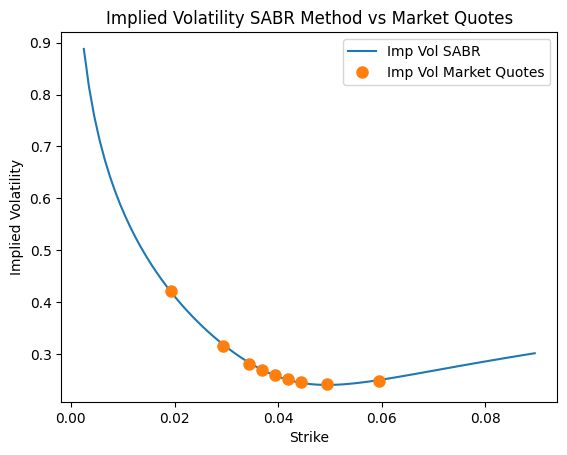

In [28]:
fig, ax = plt.subplots()
sabrcurve.plot(ax=ax)
volquotes.plot(linestyle='',marker='o',markersize=8,ax=ax)
plt.title('Implied Volatility SABR Method vs Market Quotes')
plt.ylabel('Implied Volatility')
plt.xlabel('Strike')
plt.legend();

YEs, the SABR curve fits the points well, perfectly.

### 2.3.
Suppose we want to price the `1y4y` swaption but with a far out-of-the-money strike of `5%`. 

* Use the SABR vol at this strike to price the swaption.

(Note that this strike is far outside the range for which we have market quotes, and even if we do have quotes, they likely are not liquid on a given day.)



In [29]:
NEWSTRIKE = 5/100

if doSLIM:
    beta = BETA
    nu = nustar
    rho = rhostar
    f = F
    K = NEWSTRIKE
    T = Topt
    volATM = volATM
    newvol = sabr_slim(beta,nu,rho,f,K,T,volATM)
    
else: 
    beta = BETA
    nu = nustar
    rho = rhostar
    alpha = alphastar
    f = F
    K = NEWSTRIKE
    T = Topt
    newvol = sabr(beta,nu,rho,alpha,f,K,T)

# Formula Inputs
N = 100
T = Topt
vol = newvol
strike = NEWSTRIKE
fwd = fwdswap
# Use the sum of discount 
discount = sum_discount

# Payer Swaption Price = N x Call Option Price (via Black's Formula)
newprice = N * blacks_formula(T, vol, strike, fwd, discount, isCall=True)
print(f'Price of the OTM swaption at strike {NEWSTRIKE:.2%} is ${newprice:.4f}.')


Price of the OTM swaption at strike 5.00% is $0.3179.


### 2.4.

Use the ATM implied volatility to fit $\alpha$, (sometimes denoted $\sigma_0$.) That is, for any choice of $(\rho,\nu)$, solve a quadratic equation to get $\alpha$ as a function of those two parameters, along with $\beta$, which is at its selected (not estimated) value.

Recall that we have a simple relationship between ATM vol and $\alpha$.
$$\sigma_\text{ATM} = \alpha\frac{B}{F^{1-\beta}}$$
where $B$ is defined in the discussion note. It is a quadratic expression of $\alpha$ along with $(\beta,\rho,\nu)$.

This decouples the optimization. We solve for $(\rho,\nu)$ and $\alpha$ as a function of the other two parameters.

Consider using the function `sabrATM` in `cmds/volskew.py`.

In [30]:
# Computing the SABR Parameters
# For fitting alpha, and solving for rho and nu
# Set doSlim to True

# Inputs
doSLIM = True
BETA = 0.75
F = fwdswap-1e-8
volATM = volATM

def obj_fun(xargs):
    nu = xargs[0]
    rho = xargs[1]
    alpha = xargs[2]
    
    ivolSABR = np.zeros(len(strikes))
    
    for i,strike in enumerate(strikes):
         ivolSABR[i] = sabr(BETA,nu,rho,alpha,F,strike,Topt)
    
    error = ((ivolSABR - vols.values)**2).sum()
    
    return error

def obj_fun_slim(xargs):
    nu = xargs[0]
    rho = xargs[1]
    ivolSABR = np.zeros(len(strikes))
    
    for i,strike in enumerate(strikes):
         ivolSABR[i] = sabr_slim(BETA,nu,rho,F,strike,Topt,volATM)
    
    error = ((ivolSABR - vols.values)**2).sum()
    
    return error

if not doSLIM:
    # Initial guess, nu = 0.6, rho = 0, alpha = 0.1
    x0 = np.array([.6,0,.1])
    fun = obj_fun
else:
    fun = obj_fun_slim
    # Initial guess, nu = 0.6, rho = 0, alpha = 0.1
    x0 = np.array([.6,0,.1])

optim = minimize(fun,x0)
xstar = optim.x
nustar = xstar[0]
rhostar = xstar[1]
   
if doSLIM:
    beta = BETA
    nu = nustar
    rho = rhostar
    f = F
    K = strikes # Use strikes
    T = Topt
    volATM = volATM
    alphastar = solve_alpha(beta, nu, rho, T, volATM, f)
    ivolSABR = sabr_slim(beta,nu,rho,f,K,T,volATM)
else:
    beta = BETA
    nu = nustar
    rho = rhostar
    alphastar = xstar[2] # Use the guessed value
    alpha = alphastar
    f = F
    K = strikes
    T = Topt
    ivolSABR = sabr(beta,nu,rho,alpha,f,K,T)
    
error = optim.fun

# print(f"beta: {BETA:.4f}")
# print(f"alpha: {alphastar:.4f}")
# print(f"nu: {nustar:.4f}")
# print(f"rho: {rhostar:.4f}")
# print(f"fit error: {error:.4f}")

param = pd.DataFrame([BETA, alphastar, nustar, rhostar, error],
                     index=['beta','alpha','nu','rho','fit error'],
                     columns=['SABR Parameters']).style.format('{:.4f}')
param

,SABR Parameters
beta,0.7500
alpha,0.1130
nu,0.6881
rho,-0.3465
fit error,0.0000


***

# 3. SABR and Risk Management

Consider how an **increase** of `50bps` in the underlying rate impacts the price of the `1y4y` ATM swaption.

Here, we are assuming that
* the rate change will impact the forward swap rate directly, one-for-one with other rates.
* the shift happens one week after the original quote date.

Of course, in reality, a rate change
* may price in early to some degree if it is expected
* may not impact the forward swap rate one-for-one. We would need to model how the discount curve changes and what that change (level, slope, curvature?) would do to the forward swap rate.

### 3.1

Use Black's equation to re-price the `1y4y` swaption with
* the same ATM volatility
* an underlying (forward swap) rate `increased` `50bps`.
* the same time-to-maturities. (We should decrease these all by 1/365, but we focus here on the delta effects rather than the theta. And it would be a small impact anyone.)

Report 
* the new price
* the change in price divided by `50bps`, (a numerical delta.)

In [31]:
# For a 1-year x 4-year swaption
Topt = 1
tenor_swap = 4
tenor_swaption = Topt + tenor_swap
Tswap = tenor_swaption

# Formula inputs for Forward Swap Rate
# Time for Forward Exercise = Option's Tenor
Tfwd = Topt
# Use the swaption's tenor, not just the swap
Tswap = T_swaption
freqswap = 4
discounts = curvedata['discounts']

fwdswap = calc_fwdswaprate(discounts, Tfwd, Tswap, freqswap)
print(f"The forward swap rate is: {fwdswap:.4%}")

# Calculating Swaption Price

# Compounding frequency of the Discount Curve
freqcurve = 4
# Sum of Discount Factor Calculation
period_fwd = curvedata.index.get_loc(Topt)
period_swap = curvedata.index.get_loc(Tswap)+1
step = round(freqcurve/freqswap)
sum_discount = curvedata['discounts'].iloc[period_fwd + step : period_swap : step].sum()/freqswap

# Formula Inputs
N = 100
T = Topt
vol = volATM
strike = strike_ATM
fwd = fwdswap
# Use the sum of discount 
discount = sum_discount

# Payer Swaption Price = N x Call Option Price (via Black's Formula)
swaption_price_1y4y = N * blacks_formula(T, vol, strike, fwd, discount, isCall=True)
print(f"Price for {Topt}-year {tenor_swap}-year Swaption (Original): ${swaption_price_1y4y:.4f}")

The forward swap rate is: 3.9385%
Price for 1-year 4-year Swaption (Original): $1.4362


In [32]:
# Adjusted Swap Rate
SHIFT = 50/10_000
fwdswap_adj = fwdswap + SHIFT
print(f"The new forward swap rate: {fwdswap_adj:.4%}")

# Adjusted Swaption Price
# Formula Inputs
N = 100
T = Topt
vol = volATM
strike = strike_ATM
fwd = fwdswap_adj
# Use the sum of discount 
discount = sum_discount

# Payer Swaption Price = N x Call Option Price (via Black's Formula)
swaption_price_1y4y_adj = N * blacks_formula(T, vol, strike, fwd, discount, isCall=True)
print(f"Price for {Topt}-year {tenor_swap}-year Swaption (New): ${swaption_price_1y4y_adj:.4f}")

# Numerical Delta = Change in Price divided by change in rate (in bps)
num_delta_static = (swaption_price_1y4y_adj - swaption_price_1y4y) / SHIFT
print(f"Numerical Delta: {num_delta_static:.4f}")

The new forward swap rate: 4.4385%
Price for 1-year 4-year Swaption (New): $2.5708
Numerical Delta: 226.9222


### 3.2

Now, we consider how the volatility may change with the underlying shift `up` of `50bps`.

Using the same SABR parameters from `2.1`, and the strike grid from `2.2`, plot the new SABR curve accounting for the underlying rate shifting `up` `50bps`.

In [33]:
# Inputs
SHIFT = 50/10_000

sabrcurve.rename(columns={'Imp Vol SABR':f'Imp Vol SABR Original'},inplace=True)

# Implied Volatility via SABR
if doSLIM:
    beta = BETA
    nu = nustar
    rho = rhostar
    f = F + SHIFT
    K = strikegrid
    T = Topt
    volATM = volATM
    ivolgrid = sabr_slim(beta,nu,rho,f,K,T,volATM)
    
else: 
    beta = BETA
    nu = nustar
    rho = rhostar
    alpha = alphastar
    f = F + SHIFT
    K = strikegrid
    T = Topt
    ivolgrid = sabr(beta,nu,rho,alpha,f,K,T)
    
# sabrcurve = pd.DataFrame(ivolgrid, index=strikegrid, columns=['Imp Vol SABR'])
sabrcurve[f'Imp Vol SABR: underlying + {SHIFT*10_000:.0f}bps'] = ivolgrid
sabrcurve.head()

,Imp Vol SABR Original,Imp Vol SABR: underlying + 50bps
0.0025,0.887987,0.912156
0.0035,0.814570,0.839381
0.0045,0.758906,0.784218
0.0055,0.713923,0.739652
0.0065,0.676093,0.702182


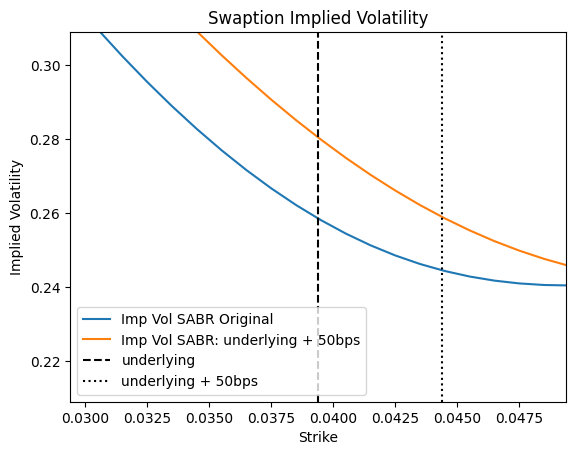

In [34]:
fig, ax = plt.subplots()
sabrcurve.plot(ax=ax)

# give limits for the x and y axis to zoom in 
plt.xlim([F-.01, F+.01])
plt.ylim([volATM-.05, volATM+.05])

# Lines for the strike price
plt.axvline(F, color='k', linestyle='--', label=f'underlying')
plt.axvline(F+SHIFT, color='k', linestyle=':', label=f'underlying + {SHIFT*10_000:.0f}bps')

plt.title('Swaption Implied Volatility')
plt.ylabel('Implied Volatility');
plt.xlabel('Strike')
plt.legend();

### 3.3

Calculate the new volatility specifically for the pre-shift ATM strike.

Use this in Black's formula similar to `3.1`, where the only change is the volatility now reflects the shift in the underlying (not the strike).

Report
* the new price
* the change in price divided by `50bps`

In [35]:
print(f"Strike ATM is: {strike_ATM:.4%}")

Strike ATM is: 3.9385%


In [36]:
doSLIM = False

# Implied Volatility via SABR
if doSLIM:
    beta = BETA
    nu = nustar
    rho = rhostar
    f = F + SHIFT
    K = strike_ATM
    T = Topt
    volATM = volATM
    ivol_new = sabr_slim(beta,nu,rho,f,K,T,volATM)
else: 
    beta = BETA
    nu = nustar
    rho = rhostar
    alpha = alphastar
    f = F + SHIFT
    K = strike_ATM
    T = Topt
    ivol_new = sabr(beta,nu,rho,alpha,f,K,T)
    
print(f"New Implied Volatility: {ivol_new:.4%}")

New Implied Volatility: 27.2950%


In [37]:
# Adjusted Swap Rate
SHIFT = 50/10_000
fwdswap_adj = fwdswap + SHIFT
print(f"The new forward swap rate: {fwdswap_adj:.4%}")

# Adjusted Swaption Price
# Formula Inputs
N = 100
T = Topt
vol = ivol_new # Use new implied vol
strike = strike_ATM
fwd = fwdswap_adj
# Use the sum of discount 
discount = sum_discount

# Payer Swaption Price = N x Call Option Price (via Black's Formula)
swaption_price_1y4y_adj_dynamic = N * blacks_formula(T, vol, strike, fwd, discount, isCall=True)
print(f"Price for {Topt}-year {tenor_swap}-year Swaption (New): ${swaption_price_1y4y_adj_dynamic:.4f}")

# Numerical Delta = Change in Price divided by change in rate (in bps)
num_delta_dynamic = (swaption_price_1y4y_adj_dynamic - swaption_price_1y4y) / SHIFT
print(f"Dynamic Delta: {num_delta_dynamic:.4f}")

The new forward swap rate: 4.4385%
Price for 1-year 4-year Swaption (New): $2.6446
Dynamic Delta: 241.6790


### 3.4

How much different is the (dynamic) delta which accounts for the shift in volatility from the (static) delta in `3.1`?

In [38]:
print(f"Static Delta: {num_delta_static:.4f}")
print(f"Dynamic Delta: {num_delta_dynamic:.4f}")

delta_change = (num_delta_dynamic - num_delta_static)/num_delta_static
print(f"Percent Change in Delta, relative to Static Delta: {delta_change:.4%}")

Static Delta: 226.9222
Dynamic Delta: 241.6790
Percent Change in Delta, relative to Static Delta: 6.5030%


***